In [1]:
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

import os

from load_Indian_pines import load_Indian_pines

We load the indian pines dataset:

In [2]:
data, raw_gt, labels_id_raw, n_classes_raw, n_pix, n_bands = load_Indian_pines()


As commonly done in the litterature when working with the indian pines dataset, we remove the classes that have too few elements. We are left with 9 classes.

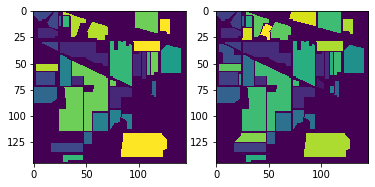

In [3]:
list_enough_data = []
idx_enough_data = 0
gt = torch.zeros(n_pix,n_pix)
labels_id = []

for i in range(n_classes_raw):
    xx, yy = torch.where(raw_gt==i+1)
    if len(xx) > 400:
        idx_enough_data += 1
        list_enough_data.append(i)
        gt[xx,yy] = idx_enough_data
        labels_id.append(labels_id_raw[i])
        #print(labels_id[idx_enough_data] +', train : 200 , test : %d'% (len(xx)-200))
n_classes = idx_enough_data

ax = plt.subplot(1, 2, 1)
plt.imshow(gt)
ax = plt.subplot(1, 2, 2)
plt.imshow(raw_gt)
plt.show()

In [4]:
n_classes

9

We display the spectra of each elements of each class along with the spatial intensity for a few spectral bands:

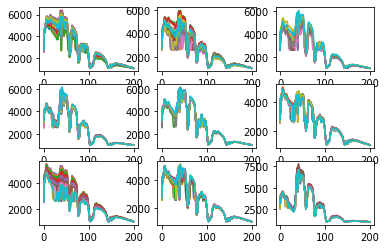

In [5]:
for i in range(n_classes):
    ax = plt.subplot(3, 3, i+1)
    xx,yy = torch.where(gt==i+1)
    plt.plot(data[xx[:20],yy[:20],:].T, label=labels_id[i])
plt.show()

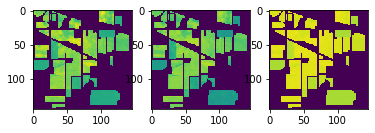

In [6]:
for i, idx in enumerate([10,120,150]):
    ax = plt.subplot(1, 3, i+1)
    plt.imshow(data[:,:,idx]*(gt>0))
plt.show()


We create the data class for our dataset along with a function to compute the accuracy of our neural nets. In labeledIndPinesDataset, additive noise is randomly added on 20% of the returned data for data augmentation.

In [8]:
class labeledIndPinesDataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, data,labels):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.labels = labels

    @staticmethod
    def add_additive_noise(data, alpha_range=(0.9, 1.1), beta=1/25):
        alpha = np.random.uniform(*alpha_range)
        noise = torch.from_numpy(np.random.normal(loc=0., scale=1.0, size=data.shape))
        return (alpha * data + beta * noise).float()
    
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        selected_data = self.data[idx]
        if np.random.random() < 0.2:
            selected_data = self.add_additive_noise(selected_data)
        return selected_data, self.labels[idx]#.unsqueeze(-1)

    
def compute_accuracy(dataloader,net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader, 0):
            spectra, labels = batch
            outputs = net(spectra.float())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

The train/eval split is done by randomly selecting 200 elements of each class for both the train and eval set:

In [9]:

xx_train = torch.tensor([]).float()
yy_train = torch.tensor([]).float()


xx_eval = torch.tensor([]).float()
yy_eval = torch.tensor([]).float()

for i in range(n_classes):
    xx,yy = torch.where(gt==i+1)
    n_in_this_class = len(xx)
    random_idx=np.arange(n_in_this_class)
    np.random.shuffle(random_idx)
    if i==0:
        xx_train = xx[random_idx[:200]]
        yy_train = yy[random_idx[:200]]
        xx_eval = xx[random_idx[200:400]]
        yy_eval = yy[random_idx[200:400]]
    else:
        xx_train = torch.cat((xx_train,xx[random_idx[:200]]))
        yy_train = torch.cat((yy_train,yy[random_idx[:200]]))
        xx_eval = torch.cat((xx_eval,xx[random_idx[200:400]]))
        yy_eval = torch.cat((yy_eval,yy[random_idx[200:400]]))

n_train_samples = xx_train.shape[0]
n_eval_samples = xx_eval.shape[0]


The data is normalized:

In [10]:
data = (data- torch.min(data))/(torch.max(data) - torch.min(data))
data = 2*(data-0.5)


We create the train and eval sets, each having n_classes x 200 = 1800 elements:

In [11]:

train_data = torch.empty(n_train_samples,n_bands)
train_labels = torch.empty(n_train_samples)
for i in range(n_train_samples):
    train_data[i,:] = data[xx_train[i],yy_train[i],:]
    train_labels[i] = (gt[xx_train[i],yy_train[i]]-1).long()
print(n_train_samples)

trainset = labeledIndPinesDataset(train_data,train_labels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True)


eval_data = torch.empty(n_eval_samples,n_bands)
eval_labels = torch.empty(n_eval_samples)
for i in range(n_eval_samples):
    eval_data[i,:] = data[xx_eval[i],yy_eval[i],:]
    eval_labels[i] = (gt[xx_eval[i],yy_eval[i]]-1).long()
print(n_eval_samples)


evalset = labeledIndPinesDataset(eval_data,eval_labels)
evalloader = torch.utils.data.DataLoader(evalset, batch_size=100,
                                          shuffle=False)


1800
1800


We define the training function along with the evaluation function of our model, which applies the model on all the hyperspectral image (including the train, eval sets and the other pixels which are thus the test set).

In [12]:
def fit_model(model,optimizer,criterion, n_epoch,trainloader,evalloader):
    eval_accuracy = torch.zeros(n_epoch, requires_grad=False)
    train_accuracy = torch.zeros(n_epoch, requires_grad=False)
    losses = torch.zeros(n_epoch, requires_grad=False)
    for epoch in range(n_epoch):  # loop over the dataset multiple times
        model.train()
        running_loss = 0
        for i, batch in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = batch
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.float())
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        model.eval()
        losses[epoch] = running_loss/len(trainloader)
        train_accuracy[epoch] = compute_accuracy(trainloader,model)
        eval_accuracy[epoch] = compute_accuracy(evalloader,model)
        print('\r [%d] loss: %.3f, train accuracy : %.2f  eval accuracy : %.2f  ' %
              (epoch + 1, losses[epoch], train_accuracy[epoch].item(), eval_accuracy[epoch].item() ), end='' )
    print('Finished Training')
    return losses, train_accuracy, eval_accuracy

def eval_model(model):
    model.eval()

    estimated_Indian_pines = torch.zeros(n_pix,n_pix)
    xx,yy = torch.where(gt>0)

    with torch.no_grad():
        for i in range(len(xx)):
            spectrum = data[xx[i],yy[i],:].unsqueeze(0)
            outputs = neural_net(spectrum.float())
            _, predicted = torch.max(outputs.data, 1)
            estimated_Indian_pines[xx[i],yy[i]] = predicted+1
    return estimated_Indian_pines

Our first neural net is a simple 4 layers fully connected neural net. This is the baseline used in the comparative review.

In [13]:

class NeuralNet(nn.Module):
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            nn.init.zeros_(m.bias)
    
    def __init__(self,n_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(200, 2048)
        self.fc2 = nn.Linear(2048, 4096)
        self.fc3 = nn.Linear(4096, 2048)
        self.fc4 = nn.Linear(2048, n_classes)
        self.dropout = nn.Dropout(p=0.5)
        self.apply(self.weight_init)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x =F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x



 [2000] loss: 0.193, train accuracy : 97.00  eval accuracy : 86.33  Finished Training


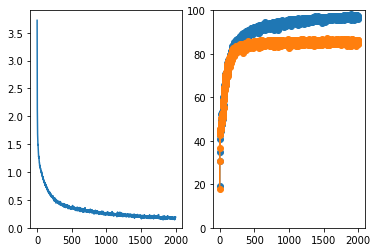

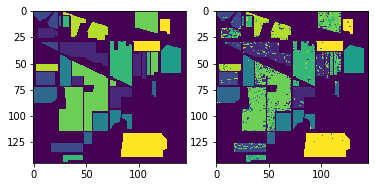

In [14]:
neural_net = NeuralNet(n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(neural_net.parameters(), lr=0.0001)
n_epoch = 2000

losses, train_accuracy, eval_accuracy = fit_model(neural_net,optimizer,criterion, n_epoch,trainloader,evalloader)
PATH_D1conv_net = './neural_net.pth'
torch.save(neural_net.state_dict(), PATH_D1conv_net)

ax = plt.subplot(1,2, 1)

plt.plot(losses)
plt.ylim(0)

ax = plt.subplot(1,2, 2)
plt.plot(train_accuracy,'o-')
plt.plot(eval_accuracy,'o-')
plt.ylim(0,100)

plt.show()

neural_net_estimated_Indian_pines = eval_model(neural_net)

ax = plt.subplot(1, 2, 1)
plt.imshow(gt)
ax = plt.subplot(1, 2, 2)
plt.imshow(neural_net_estimated_Indian_pines)
plt.show()

Our first neural net is a simple 4 layers fully connected neural net. This is the neural net presented in Hu et al. The comparative review found that this neural net along with the fully connected one perform well on indian pines.


In [15]:

class Dim1ConvNet(nn.Module):
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv1d):
            nn.init.uniform_(m.weight, -0.05, 0.05)
            nn.init.zeros_(m.bias)
    
    def _get_number_F3_inputs(self):
        with torch.no_grad():
            x = torch.zeros(1,1,self.n_bands)
            x = self.M2(self.C1(x))
        return x.numel()
    
    def __init__(self,n_classes, k1, k2, n_4):
        super(Dim1ConvNet, self).__init__()
        self.n_bands = n_bands
        self.C1 = nn.Conv1d(1, 20, k1)
        self.M2 = nn.MaxPool1d(k2)
        self.number_F3_inputs = self._get_number_F3_inputs()
        self.F3 = nn.Linear(self.number_F3_inputs, n_4)
        self.F4 = nn.Linear(n_4, n_classes)
        self.apply(self.weight_init)
        
    def forward(self, x):
        x = x.squeeze(dim=-1).squeeze(dim=-1)
        x = x.unsqueeze(dim=1)
        x = torch.tanh(self.C1(x))
        x = (self.M2(x))
        x = x.view(-1,self.number_F3_inputs)
        x = torch.tanh(self.F3(x))
        x = self.F4(x)
        return x




 [15000] loss: 0.225, train accuracy : 93.00  eval accuracy : 84.89  Finished Training


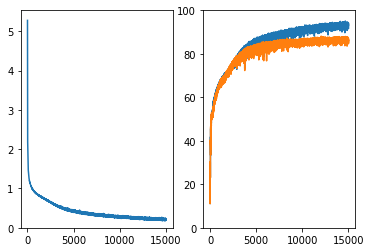

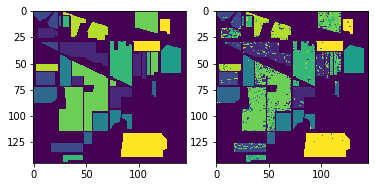

In [20]:
k1,k2,n_4 = 24,5,100

D1conv_net = Dim1ConvNet(n_bands,k1,k2,n_4,use_dropout=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(D1conv_net.parameters(), lr=0.01)
n_epoch = 15000

losses, train_accuracy, eval_accuracy = fit_model(D1conv_net,optimizer,criterion, n_epoch,trainloader,evalloader)
PATH_D1conv_net = './D1conv_net.pth'
torch.save(D1conv_net.state_dict(), PATH_D1conv_net)

ax = plt.subplot(1,2, 1)

plt.plot(losses)
plt.ylim(0)

ax = plt.subplot(1,2, 2)
plt.plot(train_accuracy,'-')
plt.plot(eval_accuracy,'-')
plt.ylim(0,100)

plt.show()

D1conv_net_estimated_Indian_pines = eval_model(D1conv_net)

ax = plt.subplot(1, 2, 1)
plt.imshow(gt)
ax = plt.subplot(1, 2, 2)
plt.imshow(D1conv_net_estimated_Indian_pines)
plt.show()